In [1]:
!pip install  pandas chardet kneed

In [2]:
# @title Создание dataframe для классификации и сохранение результатов
import csv
import pandas as pd
import chardet
import io
from google.colab import files
from typing import Dict, List, Optional, Any

# --- 3. Функция 1: Загрузка CSV файла в Colab ---
def upload_csv(encoding: Optional[str] = None) -> io.StringIO:
    """
    Загружает CSV-файл в Colab. Кодировку можно задать вручную или определить автоматически.

    Args:
        encoding (str, optional): Кодировка (например, 'utf-8', 'cp1251'). Если None — автоопределение.

    Returns:
        io.StringIO: Буфер с данными, готовый для pd.read_csv.
    """
    print("📎 Загрузи CSV-файл")
    uploaded = files.upload()
    filename = next(iter(uploaded))
    raw_data = uploaded[filename]

    # Если кодировка не задана — определяем
    if encoding is None:
        detected = chardet.detect(raw_data)['encoding']
        print(f"🔍 Автоопределена кодировка: {detected}")
        encoding = detected

        # Подстраховка: если chardet вернул что-то странное (например, MacRoman), попробуем utf-8
        suspicious_encodings = ['MacRoman', 'MacCyrillic', 'ISO-8859-1']
        if encoding in suspicious_encodings:
            print(f"⚠️  Подозрительная кодировка: {encoding}. Пробуем utf-8...")
            try:
                # Сначала пробуем utf-8
                decoded = raw_data.decode('utf-8')
                print("✅ Успешно декодировано как utf-8")
                return io.StringIO(decoded)
            except UnicodeDecodeError:
                print(f"❌ utf-8 не подошёл. Используем {encoding} как fallback.")

    # Пробуем декодировать с выбранной кодировкой
    try:
        decoded = raw_data.decode(encoding)
        print(f"✅ Используем кодировку: {encoding}")
        return io.StringIO(decoded)
    except UnicodeDecodeError as e:
        print(f"❌ Ошибка декодирования с кодировкой '{encoding}': {e}")
        # Fallback: попробуем cp1251 (часто используется для русских CSV)
        try:
            print("🔁 Пробуем fallback: cp1251")
            decoded = raw_data.decode('cp1251')
            print("✅ Успешно декодировано как cp1251")
            return io.StringIO(decoded)
        except:
            raise ValueError("Не удалось декодировать файл. Убедись, что это текстовый CSV.")


# --- 4. Функция 2: Создание DataFrame с гибкими параметрами ---
def create_dataframe_from_csv(
    csv_buffer: io.StringIO,
    nrows: Optional[int] = None,
    column_names: Optional[List[str]] = None,
    sep: str = None
) -> pd.DataFrame:
    """
    Создаёт DataFrame из буфера CSV.

    Args:
        csv_buffer (io.StringIO): Буфер с данными CSV.
        nrows (int, optional): Сколько строк прочитать. None — все.
        column_names (List[str], optional): Список имён столбцов. Если None — использовать из файла.
        sep (str, optional): Разделитель. Если None — автоопределение.

    Returns:
        pd.DataFrame
    """
    # Сохраняем позицию, чтобы можно было прочитать дважды
    csv_buffer.seek(0)

    # Автоопределение разделителя
    if sep is None:
        sample = csv_buffer.read(10000)
        sniffer = csv.Sniffer()
        sep = sniffer.sniff(sample).delimiter
        csv_buffer.seek(0)
        print(f"🔍 Определён разделитель: {repr(sep)}")

    # Чтение
    df = pd.read_csv(
        csv_buffer,
        sep=sep,
        nrows=nrows,
        names=column_names,  # если переданы — переопределяем
        header=0 if column_names is None else None  # если задали column_names — нет header в файле
    )

    print(f"✅ Загружено {len(df)} строк")
    print(f"📋 Первые строки:\n{df.head()}")
    return df

# сохранение в csv

In [3]:
# @title фильтрация dataframe
def dataframe_filter(
    df: pd.DataFrame,
    text_column: str,
    filter_condition: Optional[Dict[str, Any]] = None,
    str_format = True
) -> List[str]|pd.DataFrame:
    """
    Фильтрует DataFrame и возвращает список текстов из указанного столбца.
    Аналог SQL: SELECT text_column FROM df WHERE condition

    Args:
        df (pd.DataFrame): Датафрейм с данными.
        text_column (str): Название столбца с текстом.
        filter_condition (Dict[str, Any], optional): Условие фильтрации в формате
            {"column": "название_столбца", "value": значение} или
            {"column": "название_столбца", "values": [значение1, значение2]} для множественного выбора

    Returns:
        List[str]: Список текстов после фильтрации
    """
    # Применяем фильтр если указан
    if filter_condition:
        filtered_df = df.copy()
        column = filter_condition.get("column")
        value = filter_condition.get("value")
        values = filter_condition.get("values")

        if column and column in df.columns:
            if value is not None:
                filtered_df = filtered_df[filtered_df[column] == value]
            elif values is not None:
                filtered_df = filtered_df[filtered_df[column].isin(values)]
            else:
                print("⚠️ Указан фильтр, но не указано значение для фильтрации. Используем все строки.")
        else:
            print(f"⚠️ Столбец '{column}' не найден в DataFrame. Используем все строки.")
            filtered_df = df
    else:
        filtered_df = df

    print(f"📊 Отфильтровано {len(filtered_df)} строк из {len(df)}")

    # Возвращаем список текстов либо dataframe
    return filtered_df[text_column].tolist() if str_format else filtered_df

In [4]:
# @title алгоритмы K-MEANS
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import squareform
from sklearn.cluster import KMeans
from kneed import KneeLocator


def find_elbow_k_auto(inertia_dict, show_plot=False):
    k_range = list(inertia_dict.keys())
    inertias = list(inertia_dict.values())

    # Ищем точку "локтя"
    knee_locator = KneeLocator(
        k_range,
        inertias,
        curve='convex',
        direction='decreasing',
        online=True
    )

    optimal_k = knee_locator.knee

    if show_plot:
      plot_elbow(inertia_dict)

    return optimal_k



def compute_inertia_range(vectors, k_min=5, k_max=None):
    """
    Вычисляет inertia для диапазона числа кластеров k.

    Параметры:
        vectors : array-like, shape (n_samples, n_features)
            Матрица векторов (эмбеддингов и т.п.)
        k_min : int, optional (default=5)
            Минимальное число кластеров.
        k_max : int or None, optional (default=None)
            Максимальное число кластеров. Если None — определяется автоматически,
            но не более 50.

    Возвращает:
        dict: {k: inertia}
    """
    n_samples = len(vectors)

    # Автоопределение k_max, если не задано
    if k_max is None:
        min_cluster_size = 10
        raw_k_max = n_samples // min_cluster_size
        k_max = min(raw_k_max, 50)  # 🔒 Жёсткий лимит — не больше 50
    else:
        k_max = min(k_max, 50)  # ⚠️ Даже если передали 100 — обрезаем до 50

    # k_min должен быть меньше k_max
    k_min = max(2, k_min)  # минимум 2
    k_max = max(k_min + 1, k_max)

    # Ограничиваем количество точек расчёта (чтобы не было 50 шагов по 1)
    max_evaluations = 25
    if k_max - k_min + 1 > max_evaluations:
        # Равномерно распределяем точки
        k_range = np.linspace(k_min, k_max, num=max_evaluations, dtype=int)
        k_range = sorted(set(k_range))
    else:
        k_range = range(k_min, k_max + 1)

    # Считаем инерцию
    inertia_dict = {}
    for k in k_range:
        if k >= n_samples:
            continue  # нельзя иметь больше кластеров, чем объектов
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(vectors)
        inertia_dict[k] = kmeans.inertia_

    return inertia_dict



def plot_elbow(inertia_dict):
    """
    Строит график метода локтя.
    """
    ks = list(inertia_dict.keys())
    inertias = list(inertia_dict.values())

    plt.figure(figsize=(10, 6))
    plt.plot(ks, inertias, 'o-', linewidth=2, markersize=6)
    plt.title("Метод локтя: выбор оптимального числа кластеров")
    plt.xlabel("Число кластеров (k)")
    plt.ylabel("Inertia")
    plt.grid(True, alpha=0.3)
    plt.xticks(ks)
    plt.tight_layout()
    plt.show()


def run_kmeans(vectors, n_clusters):
    """
    Запускает K-Means с K-Means++ инициализацией.
    Возвращает: labels, centroids, inertia
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(vectors)
    centroids = kmeans.cluster_centers_
    inertia = kmeans.inertia_
    return labels, centroids, inertia




def evaluate_cluster_coherence(vectors, labels, similarity_threshold=0.35, coherence_threshold=0.8):
    """
    Оценивает когерентность каждого кластера.
    Возвращает словарь с метриками.
    """
    unique_labels = [l for l in np.unique(labels) if l != -1]
    results = {}

    for label in sorted(unique_labels):
        mask = labels == label
        cluster_vectors = vectors[mask]
        n = len(cluster_vectors)

        if n == 1:
            results[label] = {
                "size": n,
                "coherent": True,
                "similar_pairs_ratio": 1.0,
                "avg_distance": 0.0
            }
            continue

        dist_matrix = cosine_distances(cluster_vectors)
        distances = squareform(dist_matrix, checks=False)

        similar_ratio = np.mean(distances < similarity_threshold)
        avg_dist = np.mean(distances)
        is_coherent = similar_ratio >= coherence_threshold

        results[label] = {
            "size": n,
            "coherent": bool(is_coherent),
            "similar_pairs_ratio": float(similar_ratio),
            "avg_distance": float(avg_dist)
        }

    return results

In [5]:
# @title очистка кластеров
def refine_clusters(
    vectors,
    labels,
    centroids,
    coherence_results,
    min_coherence_for_cleaning=0.75,
    min_cluster_size=5
):
    """
    Очищает кластеры:
    - Если когерентность < min_coherence_for_cleaning → кластер удаляется.
    - Иначе: удаляем выбросы (векторы далеко от центроида).
    Возвращает: обновлённые метки, список осиротевших индексов.
    """
    new_labels = labels.copy()
    orphaned_indices = []

    for cluster_id, metrics in coherence_results.items():
        size = metrics["size"]
        ratio = metrics["coherent"]

        if not metrics["coherent"]:
            # Удаляем весь кластер
            mask = labels == cluster_id
            orphaned_indices.extend(np.where(mask)[0])
            new_labels[mask] = -1  # шум
            print(f"❌ Кластер {cluster_id} (размер {size}) удалён: низкая когерентность")
        else:
            # Очищаем от выбросов
            mask = labels == cluster_id
            cluster_vectors = vectors[mask]
            indices = np.where(mask)[0]
            centroid = centroids[cluster_id]

            # Расстояние до центроида
            distances = cosine_distances(cluster_vectors, [centroid]).flatten()
            # Порог: 80-й перцентиль или фиксированный
            threshold = np.percentile(distances, 80)
            inliers = distances <= threshold

            # Переназначаем только "хорошие"
            new_mask = np.zeros_like(mask)
            new_mask[indices[inliers]] = True
            new_labels[new_mask] = cluster_id

            # Остальные — осиротели
            outliers = indices[~inliers]
            orphaned_indices.extend(outliers)

            print(f"✅ Кластер {cluster_id} (размер {size}) очищен: {len(inliers)} осталось")

    return new_labels, orphaned_indices

In [6]:
# @title переназначение кластеров
def reassign_orphans_to_existing(
    vectors,
    orphaned_indices,
    labels,
    centroids,
    existing_coherence,
    coherence_threshold=0.9,
    distance_threshold=0.15
):
    """
    Пытается вернуть осиротевшие векторы в "идеальные" кластеры (coherence > threshold).
    """
    new_labels = labels.copy()
    reassigned = 0

    # Только "идеальные" кластеры
    ideal_clusters = [
        cid for cid, res in existing_coherence.items()
        if res["coherent"] and res["similar_pairs_ratio"] >= coherence_threshold
    ]
    ideal_centroids = {cid: centroids[cid] for cid in ideal_clusters}

    for idx in orphaned_indices:
        vec = vectors[idx]
        best_cid = None
        min_dist = float('inf')

        for cid, cent in ideal_centroids.items():
            dist = cosine_distances([vec], [cent])[0][0]
            if dist < min_dist and dist < distance_threshold:
                min_dist = dist
                best_cid = cid

        if best_cid is not None:
            new_labels[idx] = best_cid
            reassigned += 1
            print(f"🔁 Вектор {idx} добавлен в кластер {best_cid} (расстояние: {min_dist:.3f})")

    print(f"✅ {reassigned} векторов возвращены в идеальные кластеры")
    return new_labels

In [7]:
# @title перекластеризация остатков
from sklearn.cluster import KMeans

def cluster_remaining_orphans(
    vectors,
    labels,
    orphaned_indices,
    mean_cluster_size
):
    """
    Кластеризует оставшиеся осиротевшие векторы.
    Число новых кластеров = len(orphans) // mean_cluster_size
    """
    remaining_indices = [i for i in orphaned_indices if labels[i] == -1]
    if not remaining_indices:
        return labels

    remaining_vectors = vectors[remaining_indices]
    n_remaining = len(remaining_vectors)
    n_new_clusters = max(1, n_remaining // mean_cluster_size)

    if n_remaining < 2 * n_new_clusters:
        print("⚠️ Слишком мало векторов для новых кластеров — пропущено")
        return labels

    kmeans = KMeans(n_clusters=n_new_clusters, random_state=42)
    new_cluster_labels = kmeans.fit_predict(remaining_vectors)

    # Новые ID кластеров (старшие номера)
    offset = labels.max() + 1
    for i, label in enumerate(new_cluster_labels):
        global_idx = remaining_indices[i]
        labels[global_idx] = offset + label

    print(f"🆕 Сформировано {n_new_clusters} новых кластеров из {n_remaining} векторов")
    return labels

In [8]:
# @title финальная статистика
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import squareform


def generate_final_report(vectors, labels, reviews, similarity_threshold=0.35):
    """
    Печатает подробный отчёт по финальным кластерам.
    """

    def is_cluster_coherent(cluster_vectors, sim_thresh, coh_thresh=0.8):
        """
        Определяет, является ли кластер когерентным.
        """
        if len(cluster_vectors) == 1:
            return True
        dist_matrix = cosine_distances(cluster_vectors)
        distances = squareform(dist_matrix, checks=False)
        similar_ratio = np.mean(distances < sim_thresh)
        return similar_ratio >= coh_thresh

    # --- Вывод таблицы ---
    unique_labels = sorted([l for l in np.unique(labels) if l != -1])
    if not unique_labels:
        print("❌ Нет валидных кластеров.")
        return

    print(f"\n{'Кластер':<8} {'Размер':<6} {'Статус':<10} {'% схожих':<10} {'Ср. расст.'}")
    print("-" * 50)

    clean_count = 0

    for label in unique_labels:
        mask = labels == label
        cluster_vectors = vectors[mask]
        n = len(cluster_vectors)

        if n == 1:
            print(f"{label:<8} {n:<6} {'✅ Чистый':<10} {'100%':<10} {'–':<8}")
            clean_count += 1
            continue

        # Матрица расстояний
        dist_matrix = cosine_distances(cluster_vectors)
        distances = squareform(dist_matrix, checks=False)
        similar_ratio = np.mean(distances < similarity_threshold)
        avg_distance = np.mean(distances)
        coherent = is_cluster_coherent(cluster_vectors, similarity_threshold)
        status = "✅ Чистый" if coherent else "❌ Шумный"
        ratio_pct = f"{similar_ratio * 100:.1f}%"

        print(f"{label:<8} {n:<6} {status:<10} {ratio_pct:<10} {avg_distance:.3f}")

        if coherent:
            clean_count += 1

    # --- Сводка ---
    total = len(unique_labels)
    noisy_count = total - clean_count
    print("-" * 50)
    print(f"📊 Итого: {clean_count} чистых, {noisy_count} шумных из {total} кластеров")

In [9]:
# @title сохраняем результаты в исходный dataframe + csv
import pandas as pd

def add_column_by_indices(
    source_df: pd.DataFrame,
    new_col_name: str,
    new_col_data: list,
    indices=None,
    changed_df=None,
    csv_file_name: str = None,
    default_value=-1
) -> pd.DataFrame:
    """
    Добавляет новый столбец в source_df, записывая данные из new_col_data
    только в строки, соответствующие переданным индексам (или changed_df).

    Параметры:
    -----------
    source_df : pd.DataFrame
        Исходный DataFrame, куда нужно добавить колонку.
    new_col_name : str
        Имя новой колонки.
    new_col_data : list или array
        Данные для записи (например, метки кластеров). Длина должна совпадать с числом индексов.
    indices : list или pd.Index, optional
        Список индексов, куда нужно вставить данные.
    changed_df : pd.DataFrame, optional
        Альтернатива indices — если передан, берётся его индекс.
    csv_file_name : str, optional
        Если указано — сохраняет результат в CSV.
    default_value : any, optional
        Значение для строк, не вошедших в indices (по умолчанию -1).

    Возвращает:
    ------------
    pd.DataFrame с новой колонкой.
    """

    # Создаём копию, чтобы не менять оригинал
    result_df = source_df.copy()

    # Определяем, откуда брать индексы
    if changed_df is not None:
        indices_to_use = changed_df.index
    elif indices is not None:
        indices_to_use = indices
    else:
        raise ValueError("Нужно указать либо changed_df, либо indices")

    # Проверка длины
    if len(new_col_data) != len(indices_to_use):
        raise ValueError(
            f"Длина данных ({len(new_col_data)}) не совпадает "
            f"с числом индексов ({len(indices_to_use)})"
        )

    # Добавляем колонку с дефолтным значением
    result_df[new_col_name] = default_value

    # Вставляем данные по индексам
    result_df.loc[indices_to_use, new_col_name] = new_col_data

    # Сохраняем в CSV, если нужно
    if csv_file_name is not None:
        result_df.to_csv(csv_file_name, index=False)
        print(f"Результат сохранён в {csv_file_name}")

    return result_df

In [10]:
# @title запуск пайплайна с несколькими значениями n_clusters
import pandas as pd
import numpy as np
from typing import List, Dict

def multi_pipeline(
    vectors,
    reviews,
    k_range: List[int],
    similarity_threshold: float = 0.35,
    coherence_threshold: float = 0.8,
    min_coherence_for_cleaning: float = 0.75,
    min_cluster_size: int = 5,
    mean_cluster_size_factor: float = 0.8
):
    """
    Запускает пайплайн кластеризации для нескольких значений n_clusters.
    Возвращает сводную таблицу с метриками.
    """
    results = []

    for n_clusters in k_range:
        print(f"\n🔄 Запуск для n_clusters = {n_clusters}")
        print("-" * 50)

        # 1. K-Means
        labels, centroids, inertia = run_kmeans(vectors, n_clusters)

        # 2. Оценка когерентности ДО очистки
        coherence_results = evaluate_cluster_coherence(
            vectors, labels, similarity_threshold, coherence_threshold
        )

        # 3. Очистка кластеров
        cleaned_labels, orphaned_indices = refine_clusters(
            vectors, labels, centroids, coherence_results,
            min_coherence_for_cleaning=min_coherence_for_cleaning,
            min_cluster_size=min_cluster_size
        )

        # 4. Переназначение в идеальные кластеры
        final_labels = reassign_orphans_to_existing(
            vectors, orphaned_indices, cleaned_labels, centroids, coherence_results
        )

        # 5. Перекластеризация остатков
        mean_size = np.mean([r["size"] for r in coherence_results.values()]) * mean_cluster_size_factor
        final_labels = cluster_remaining_orphans(
            vectors, final_labels, orphaned_indices, mean_size
        )

        # 6. Финальная оценка
        final_coherence = evaluate_cluster_coherence(
            vectors, final_labels, similarity_threshold, coherence_threshold
        )
        unique_labels = [l for l in np.unique(final_labels) if l != -1]
        total_clusters = len(unique_labels)
        clean_clusters = sum(1 for r in final_coherence.values() if r["coherent"])

        # Среднее качество
        coherent_ratios = [r["similar_pairs_ratio"] for r in final_coherence.values()]
        avg_coherence = np.mean(coherent_ratios) if coherent_ratios else 0

        # Сохраняем результат
        results.append({
            "n_clusters": n_clusters,
            "inertia": inertia,
            "total_after": total_clusters,
            "clean_after": clean_clusters,
            "clean_ratio": clean_clusters / total_clusters if total_clusters > 0 else 0,
            "avg_coherence": avg_coherence,
            "orphaned_count": len(orphaned_indices)
        })

        # Сохраняем финальный результат в CSV (опционально)
        df_final = pd.DataFrame({
            'review_short': reviews,
            'cluster_id': final_labels
        })
        df_final.to_csv(f"clusters_final_k{n_clusters}.csv", index=False, encoding='utf-8')
        print(f"✅ Сохранено: clusters_final_k{n_clusters}.csv")

    # Возвращаем сводную таблицу
    results_df = pd.DataFrame(results)
    return results_df

In [11]:
# Загружаем отредактированный файл с проверенными и отредактированными короткими отзывами
csv_short = upload_csv(encoding='utf-8')

📎 Загрузи CSV-файл


Saving categories_sammary_gpt20.csv to categories_sammary_gpt20.csv
✅ Используем кодировку: utf-8


In [12]:
df_short = create_dataframe_from_csv(
    csv_short,
    sep=','
)

✅ Загружено 4896 строк
📋 Первые строки:
                                             summary              category
0  Приложение мобильного банка удобно, быстро и п...  Мобильное приложение
1                                        Газпромбанк                  Банк
2  Положительное мнение о привлекательных условия...                Вклады
3  Положительное мнение о выгодных накопительных ...   Накопительные счета
4  Хорошие предложения по дебетовым картам с кэшб...       Дебетовые карты


In [ ]:
df_short_ = dataframe_filter(
    df_short,
    'review_short',
    {'column':'category','values':['Дебетовая карта', 'Кредитная карта']},
    str_format = False
)
type(df_short_)

📊 Отфильтровано 395 строк из 4896


pandas.core.frame.DataFrame

In [13]:
# Очищаем только колонку 'review_short', сохраняя индексы
df_clean = df_short.dropna(subset=['category']).copy()
df_clean['category'] = df_clean['category'].astype(str).str.strip()
# Убираем пустые строки (после strip)
df_clean = df_clean[df_clean['category'].str.len() > 0]

# Теперь в df_clean остались только "хорошие" строки, и их индексы — из оригинального df_short
list_short_reviews = df_clean['category'].tolist()
print(f"Осталось текстов для кластеризации: {len(list_short_reviews)}")

Осталось текстов для кластеризации: 4896


In [14]:
df_clean.head(10)

,summary,category
0,"Приложение мобильного банка удобно, быстро и п...",Мобильное приложение
1,Газпромбанк,Банк
2,Положительное мнение о привлекательных условия...,Вклады
3,Положительное мнение о выгодных накопительных ...,Накопительные счета
4,Хорошие предложения по дебетовым картам с кэшб...,Дебетовые карты
5,Проблемы с поддержкой банка,Поддержка
6,Обслуживание карты бесплатно,Карта
7,Поддержка работает на 4 из 5,Поддержка
8,Онлайн банк прост и понятен,Онлайн банк
9,Кэшбэк начисляется стабильно,Кэшбэк


In [ ]:
#df_short_.head(10)

In [16]:
from sentence_transformers import SentenceTransformer
# получение эмбеддингов для кластеризации
model = SentenceTransformer("intfloat/multilingual-e5-large")
#model = SentenceTransformer("cointegrated/rubert-tiny2")
vectors_short = model.encode(list_short_reviews)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

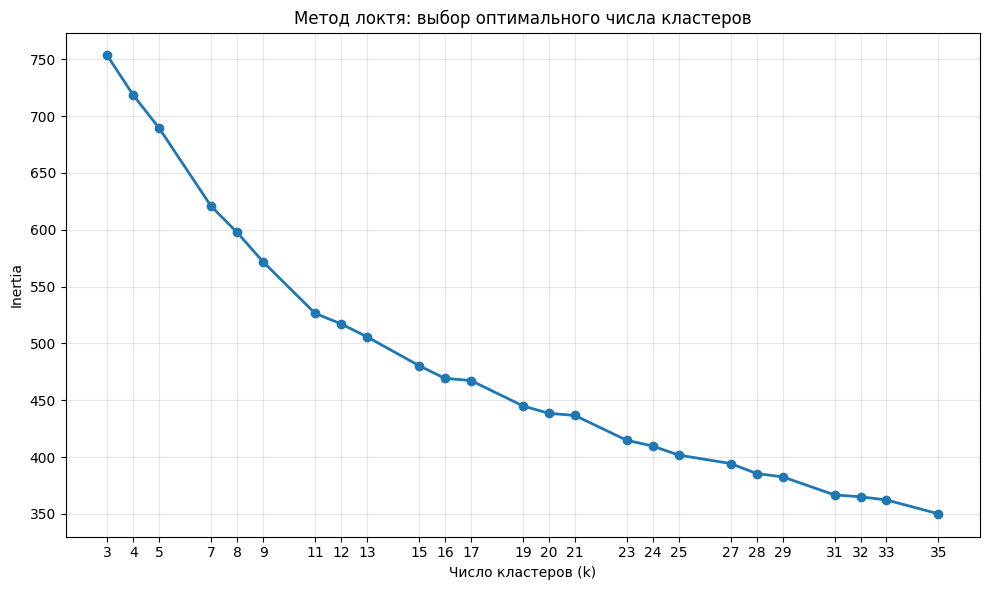

optimal_clusters_n=np.int64(15)


In [17]:
# Этап 0: Метод локтя - выбираем оптимальное число кластеров по графику
inertia_dict = compute_inertia_range(vectors_short, k_min=3, k_max=35)
optimal_clusters_n = find_elbow_k_auto(inertia_dict, show_plot=True)
print(f'{optimal_clusters_n=}')



In [31]:
# Выбираем k, например:
optimal_k = 17

# Этап 1: Кластеризация
labels, centroids, inertia = run_kmeans(vectors_short, n_clusters=optimal_k)

# Этап 2: Оценка
coherence_results = evaluate_cluster_coherence(
    vectors=vectors_short,
    labels=labels,
    similarity_threshold=0.15,
    coherence_threshold=0.75
)

# Выводим результаты
for cluster_id, metrics in coherence_results.items():
    print(f"Кластер {cluster_id}: {metrics}")

pos_values = [value['coherent'] for value in coherence_results.values() if value['coherent']==True]
print(f'Хороших кластеров: {len(pos_values)} из {len(coherence_results)}')

Кластер 0: {'size': 117, 'coherent': True, 'similar_pairs_ratio': 0.7960506926024168, 'avg_distance': 0.11728551238775253}
Кластер 1: {'size': 424, 'coherent': True, 'similar_pairs_ratio': 0.9996989160979526, 'avg_distance': 0.03331850469112396}
Кластер 2: {'size': 474, 'coherent': True, 'similar_pairs_ratio': 0.9996788610271095, 'avg_distance': 0.01712701842188835}
Кластер 3: {'size': 228, 'coherent': True, 'similar_pairs_ratio': 0.9162222737460392, 'avg_distance': 0.0990934893488884}
Кластер 4: {'size': 137, 'coherent': True, 'similar_pairs_ratio': 1.0, 'avg_distance': 0.013749021105468273}
Кластер 5: {'size': 96, 'coherent': False, 'similar_pairs_ratio': 0.6098684210526316, 'avg_distance': 0.10353834927082062}
Кластер 6: {'size': 214, 'coherent': True, 'similar_pairs_ratio': 0.8118116800491422, 'avg_distance': 0.08592621982097626}
Кластер 7: {'size': 240, 'coherent': True, 'similar_pairs_ratio': 0.998047419804742, 'avg_distance': 0.024847839027643204}
Кластер 8: {'size': 227, 'coher

In [32]:
# Очистка
new_labels, orphaned_indices = refine_clusters(
    vectors_short, labels, centroids, coherence_results,
    min_coherence_for_cleaning=0.75,
    min_cluster_size=5
)

# Переназначение в идеальные
final_labels = reassign_orphans_to_existing(
    vectors_short, orphaned_indices, new_labels, centroids, coherence_results
)

# Перекластеризация остатков
mean_size = np.mean([r["size"] for r in coherence_results.values()])
final_labels = cluster_remaining_orphans(
    vectors_short, final_labels, orphaned_indices, mean_size
)



✅ Кластер 0 (размер 117) очищен: 117 осталось
✅ Кластер 1 (размер 424) очищен: 424 осталось
✅ Кластер 2 (размер 474) очищен: 474 осталось
✅ Кластер 3 (размер 228) очищен: 228 осталось
✅ Кластер 4 (размер 137) очищен: 137 осталось
❌ Кластер 5 (размер 96) удалён: низкая когерентность
✅ Кластер 6 (размер 214) очищен: 214 осталось
✅ Кластер 7 (размер 240) очищен: 240 осталось
✅ Кластер 8 (размер 227) очищен: 227 осталось
❌ Кластер 9 (размер 775) удалён: низкая когерентность
❌ Кластер 10 (размер 237) удалён: низкая когерентность
✅ Кластер 11 (размер 345) очищен: 345 осталось
✅ Кластер 12 (размер 204) очищен: 204 осталось
❌ Кластер 13 (размер 252) удалён: низкая когерентность
✅ Кластер 14 (размер 263) очищен: 263 осталось
❌ Кластер 15 (размер 366) удалён: низкая когерентность
✅ Кластер 16 (размер 297) очищен: 297 осталось
🔁 Вектор 56 добавлен в кластер 3 (расстояние: 0.133)
🔁 Вектор 58 добавлен в кластер 3 (расстояние: 0.133)
🔁 Вектор 271 добавлен в кластер 16 (расстояние: 0.127)
🔁 Вектор 33

In [33]:
# Отчёт
generate_final_report(vectors_short, final_labels, list_short_reviews)



Кластер  Размер Статус     % схожих   Ср. расст.
--------------------------------------------------
0        94     ✅ Чистый   100.0%     0.096
1        519    ✅ Чистый   100.0%     0.064
2        488    ✅ Чистый   100.0%     0.023
3        766    ✅ Чистый   100.0%     0.161
4        170    ✅ Чистый   100.0%     0.056
6        208    ✅ Чистый   100.0%     0.083
7        244    ✅ Чистый   100.0%     0.028
8        253    ✅ Чистый   100.0%     0.027
11       285    ✅ Чистый   100.0%     0.094
12       219    ✅ Чистый   100.0%     0.041
14       233    ✅ Чистый   100.0%     0.093
16       1228   ✅ Чистый   100.0%     0.176
17       189    ✅ Чистый   100.0%     0.203
--------------------------------------------------
📊 Итого: 13 чистых, 0 шумных из 13 кластеров


In [35]:
df_with_clusters = add_column_by_indices(
    source_df=df_short,
    new_col_name='cluster',
    new_col_data=labels,
    changed_df=df_clean,  # используем его индекс
    csv_file_name='reviews_with_clusters_clean.csv',
    default_value=-1
)

Результат сохранён в reviews_with_clusters_clean.csv


In [36]:
df = pd.read_csv('reviews_with_clusters_clean.csv')
df

,summary,category,cluster
0,"Приложение мобильного банка удобно, быстро и п...",Мобильное приложение,7
1,Газпромбанк,Банк,10
2,Положительное мнение о привлекательных условия...,Вклады,12
3,Положительное мнение о выгодных накопительных ...,Накопительные счета,4
4,Хорошие предложения по дебетовым картам с кэшб...,Дебетовые карты,1
...,...,...,...
4891,Пользователь уточнял возможность увеличения ли...,Кредитная карта,1
4892,"Бот в чате ответил на запрос пользователя, пре...",Бот,15
4893,Получение несанкционированных SMS о входе в пр...,СМС,15
4894,"Обращение в чат поддержки, оператор задала воп...",Чат,15


In [37]:
import pandas as pd
from collections import Counter

# Загрузка данных из CSV файла
df = pd.read_csv('reviews_with_clusters_clean.csv')

# Убедимся, что review_short — строковый тип
df['category'] = df['category'].astype(str)

# Функция для определения самого частого наименования в группе
def most_common_name(texts):
    counter = Counter(texts)
    most_common = counter.most_common(1)
    return most_common[0][0] if most_common else ''

# Группируем по cluster_id и получаем наиболее частое review_short для каждого кластера
cluster_names = df.groupby('cluster')['category'].apply(most_common_name).reset_index()

# Переименовываем колонку для более понятного названия
cluster_names.rename(columns={'category': 'claster_name'}, inplace=True)

# Объединяем с исходным DataFrame, добавляя колонку claster_name к каждой строке
df = pd.merge(df, cluster_names, on='cluster', how='left')

# Сохраняем или выводим результат
df.to_csv('clusters_with_names.csv', index=False, encoding='utf-8')
df['claster_name'].value_counts()

,count
claster_name,
Консультация,775
Служба поддержки,474
Дебетовая карта,424
Доставка,366
Доставка карты,345
Курьерская служба,297
Банковский офис,263
Перевод средств,252
Мобильное приложение,240


Batches:   0%|          | 0/153 [00:00<?, ?it/s]

/tmp/ipython-input-2887455792.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_clusters))


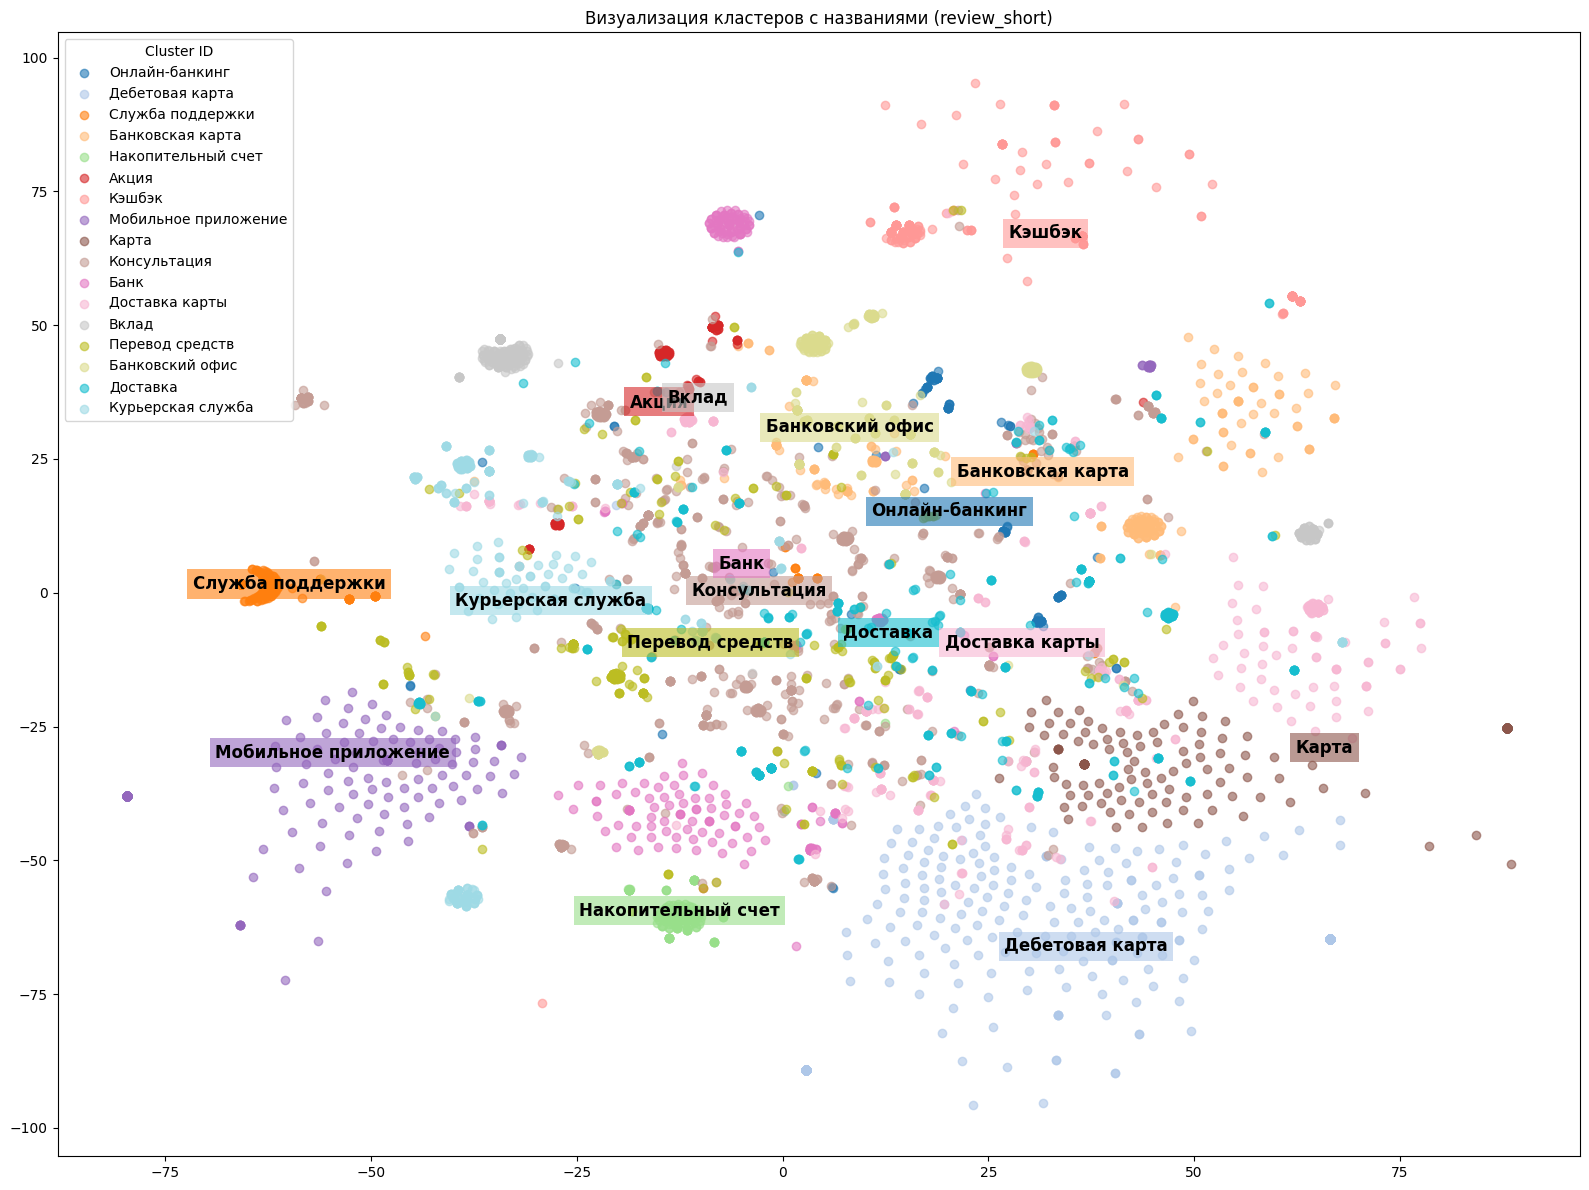

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE

# Загрузка данных
df = pd.read_csv('clusters_with_names.csv')  # Используем датафрейм с названиями кластеров

# Подготовить тексты для эмбеддингов
texts = df['category'].astype(str).tolist()

# Получить эмбеддинги с помощью SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')  # или другая модель
embeddings = model.encode(texts, show_progress_bar=True)

# Снизить размерность для визуализации (2D)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Цвета для кластеров
clusters = df['cluster'].values
unique_clusters = np.unique(clusters)
colors = plt.cm.get_cmap('tab20', len(unique_clusters))

plt.figure(figsize=(16, 12))

# Рисуем точки по кластерам
for i, cluster in enumerate(unique_clusters):
    cluster_name = df.loc[df['cluster'] == cluster, 'claster_name'].iloc[0]
    idx = clusters == cluster
    plt.scatter(
        embeddings_2d[idx, 0],
        embeddings_2d[idx, 1],
        # Получаем название кластера из df по cluster_id
        # Используем 'cluster_name' в качестве метки (label)
        label=cluster_name,
        alpha=0.6,
        color=colors(i)
    )

# Для каждого кластера подписываем его наиболее частое название в центре кластера
cluster_centers = []
for cluster in unique_clusters:
    idx = np.where(clusters == cluster)[0]
    center_x = embeddings_2d[idx, 0].mean()
    center_y = embeddings_2d[idx, 1].mean()
    cluster_centers.append((center_x, center_y))

    # Получаем название кластера из df по cluster_id
    cluster_name = df.loc[df['cluster'] == cluster, 'claster_name'].iloc[0]
# Для каждого кластера подписываем его наиболее частое название в центре кластера
for i, cluster in enumerate(unique_clusters): # *** ИЗМЕНЕНИЕ: добавлено i для доступа к цвету ***
    idx = np.where(clusters == cluster)[0]
    center_x = embeddings_2d[idx, 0].mean()
    center_y = embeddings_2d[idx, 1].mean()

    # Получаем название кластера из df по cluster_id
    cluster_name = df.loc[df['cluster'] == cluster, 'claster_name'].iloc[0]

    plt.text(
        center_x,
        center_y,
        cluster_name,
        fontsize=12,  # *** ИЗМЕНЕНИЕ 1: Шрифт покрупнее ***
        weight='bold',
        ha='center',
        va='center',
        bbox=dict(
            facecolor=colors(i),  # *** ИЗМЕНЕНИЕ 2: Цвет фона берем из палитры кластера ***
            alpha=0.6,            # Сохраняем прозрачность для читабельности
            edgecolor='none'
        )
    )

plt.title('Визуализация кластеров с названиями (review_short)')
plt.legend(title='Cluster ID', loc='upper left') #bbox_to_anchor=(1.05, 1)
plt.tight_layout()
plt.show()

In [35]:
#Итоговый список категорий

categories_list = [
    "Карты",
    "Банкоматы",
    "Кэшбэк / Бонусы",
    "Обслуживание в офисе",
    "Вклады",
    "Кредиты",
    "Курьерская служба",
    "Приложение / сайт",
    "Служба поддержки",
    "Счета",
    "Прочие услуги"
]


In [ ]:
# графики
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# Преобразуем дату в правильный формат
df_with_clusters['date'] = pd.to_datetime(df_with_clusters['data(review_dttm)'], format='%d.%m.%Y', errors='coerce')

# Посмотрим на структуру данных
print(df_with_clusters.info())
print(df_with_clusters.head())
print(f"Уникальные кластеры: {sorted(df_with_clusters['cluster'].unique())}")
print(f"Количество записей: {len(df_with_clusters)}")

In [ ]:
import seaborn as sns
from datetime import datetime

# Настройка стиля графиков
plt.style.use('default')
sns.set_palette("husl")

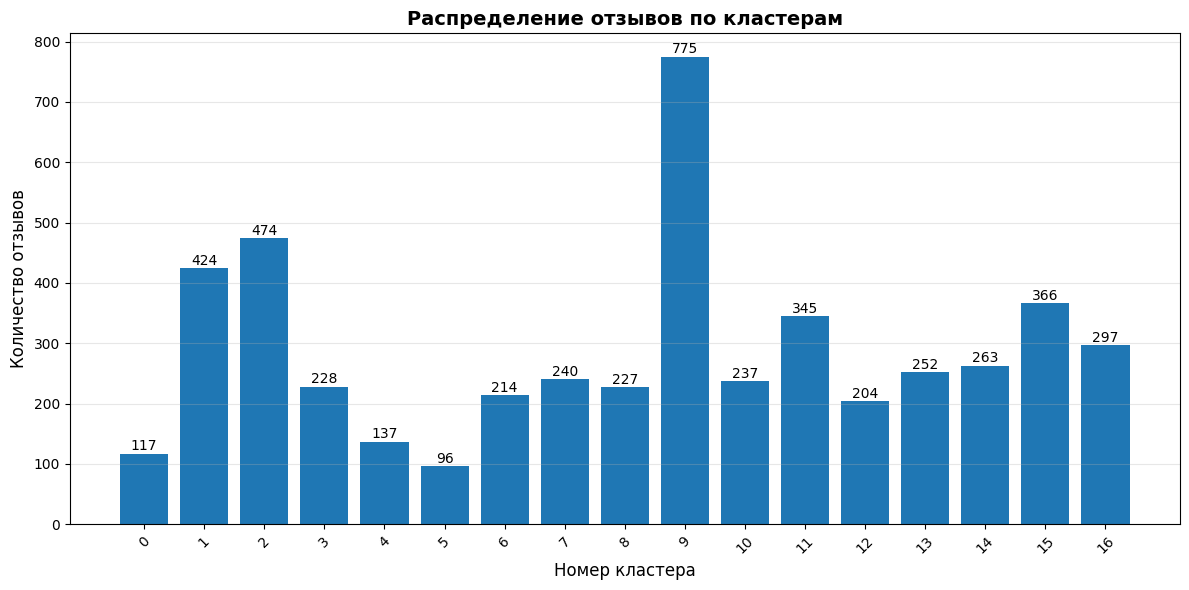

In [41]:


# 1. СТОЛБЧАТАЯ ДИАГРАММА - РАСПРЕДЕЛЕНИЕ ПО КЛАСТЕРАМ
plt.figure(figsize=(12, 6))
cluster_counts = df_with_clusters['cluster'].value_counts().sort_index()
bars = plt.bar(cluster_counts.index.astype(str), cluster_counts.values)

# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom')

plt.title('Распределение отзывов по кластерам', fontsize=14, fontweight='bold')
plt.xlabel('Номер кластера', fontsize=12)
plt.ylabel('Количество отзывов', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



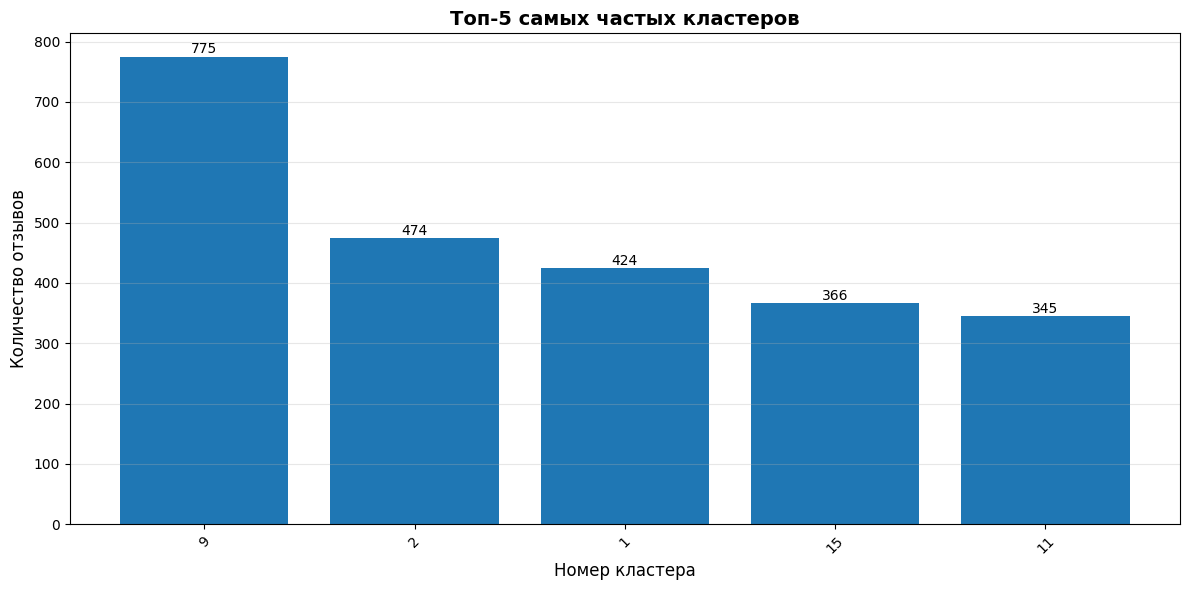

In [42]:
# 2. ТОП-<N> САМЫХ ЧАСТЫХ КЛАСТЕРОВ
top_n = 5
plt.figure(figsize=(12, 6))
top_clusters = df_with_clusters['cluster'].value_counts().head(top_n)
bars = plt.bar(top_clusters.index.astype(str), top_clusters.values)

# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom')

plt.title(f'Топ-{top_n} самых частых кластеров', fontsize=14, fontweight='bold')
plt.xlabel('Номер кластера', fontsize=12)
plt.ylabel('Количество отзывов', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



In [ ]:
# 3. ДИНАМИКА КЛАСТЕРОВ ВО ВРЕМЕНИ (ПО МЕСЯЦАМ)
# Создаем колонку с месяцем и годом
df_with_clusters['month_year'] = df_with_clusters['date'].dt.to_period('M')

# Группируем по месяцу и кластеру
monthly_clusters = df_with_clusters.groupby(['month_year', 'cluster']).size().unstack(fill_value=0)

# Берем топ-5 кластеров для визуализации
top_5_clusters = df_with_clusters['cluster'].value_counts().head(5).index
monthly_top = monthly_clusters[top_5_clusters]

plt.figure(figsize=(14, 8))
for cluster in top_5_clusters:
    plt.plot(monthly_top.index.astype(str), monthly_top[cluster],
             marker='o', linewidth=2, markersize=4, label=f'Кластер {cluster}')

plt.title('Динамика топ-5 кластеров по месяцам', fontsize=14, fontweight='bold')
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество отзывов', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()






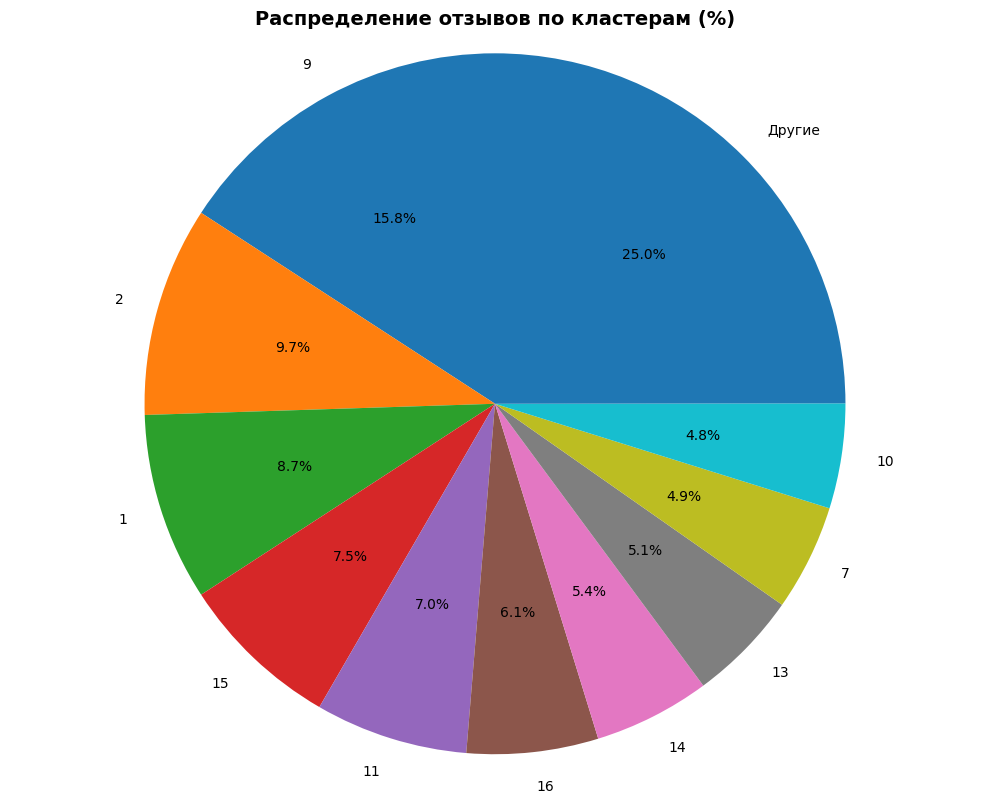

In [43]:
# 5. КРУГОВАЯ ДИАГРАММА РАСПРЕДЕЛЕНИЯ КЛАСТЕРОВ
plt.figure(figsize=(10, 8))
cluster_percentages = df_with_clusters['cluster'].value_counts(normalize=True) * 100
top_10 = cluster_percentages.head(10)
other = cluster_percentages[10:].sum()
if other > 0:
    top_10['Другие'] = other

wedges, texts, autotexts = plt.pie(top_10.values, labels=top_10.index,
                                   autopct='%1.1f%%', startangle=90)
plt.title('Распределение отзывов по кластерам (%)', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

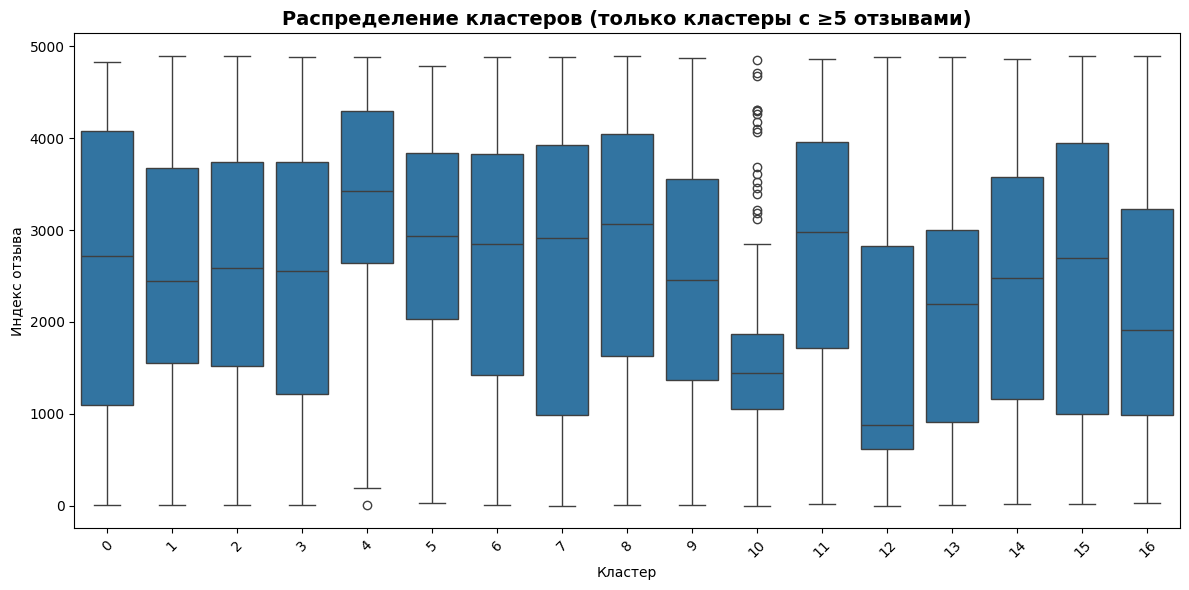

In [45]:
import seaborn as sns
# 6. ЯЩИК С УСАМИ ДЛЯ РАСПРЕДЕЛЕНИЯ КЛАСТЕРОВ
plt.figure(figsize=(12, 6))
# Берем только кластеры с достаточным количеством данных для boxplot
filtered_clusters = df_with_clusters['cluster'].value_counts()
valid_clusters = filtered_clusters[filtered_clusters >= 5].index
filtered_df = df_with_clusters[df_with_clusters['cluster'].isin(valid_clusters)]

sns.boxplot(x='cluster', y=filtered_df.index, data=filtered_df)
plt.title('Распределение кластеров (только кластеры с ≥5 отзывами)', fontsize=14, fontweight='bold')
plt.xlabel('Кластер')
plt.ylabel('Индекс отзыва')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()